In [3]:
!pip install neurokit2

In [4]:
import pandas as pd
import os
import numpy as np
import neurokit2 as nk

In [5]:
from google.colab import drive
drive.mount('/content/drive')

local_folder_path = '/content/drive/My Drive/ecg_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
csv_files = [file for file in os.listdir(local_folder_path) if file.endswith('.csv')]

In [7]:
dataframes = []
for file in csv_files:
    file_path = os.path.join(local_folder_path, file)
    data = pd.read_csv(file_path)
    dataframes.append(data)
df = pd.concat(dataframes, ignore_index=True)

In [8]:
df['Label'].value_counts()

0.0    28955090
1.0       44695
Name: Label, dtype: int64

In [9]:
data = df.sample(frac = 0.1, random_state = 1)

In [10]:
data.drop(['Time'], axis = 1, inplace = True)

In [11]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

X = X.values.reshape(-1,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
peak = data[data['Label']==1]
not_peak = data[data['Label']==0]

outlier_fraction = len(peak)/float(len(not_peak))

In [13]:
print("outlier_fraction : {}".format(outlier_fraction))
print("Peak : {}".format(len(peak)))
print("Not Peak : {}".format(len(not_peak)))

outlier_fraction : 0.0015472295266651885
Peak : 4480
Not Peak : 2895498


In [14]:
from sklearn.ensemble import IsolationForest

In [14]:
iso = IsolationForest(n_estimators = 100, max_samples=len(X_train), contamination=outlier_fraction, random_state=42, verbose=0)
iso.fit(X_train,y_train)

IsolationForest(contamination=0.0015472295266651885, max_samples=2319982,
                random_state=42)

In [15]:
y_pred = iso.predict(X_test)

In [16]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [17]:
n_errors = (y_pred != y_test).sum()
n_errors

1805

In [15]:
iso_200 = IsolationForest(n_estimators = 200, max_samples=len(X_train), contamination=outlier_fraction, random_state=42, verbose=0)
iso_200.fit(X_train,y_train)

IsolationForest(contamination=0.0015472295266651885, max_samples=2319982,
                n_estimators=200, random_state=42)

In [16]:
y_pred_200 = iso_200.predict(X_test)

In [17]:
y_pred_200[y_pred_200 == 1] = 0
y_pred_200[y_pred_200 == -1] = 1

In [18]:
n_errors_200 = (y_pred_200 != y_test).sum()
n_errors_200

1800

In [13]:
iso_300 = IsolationForest(n_estimators = 300, max_samples=len(X_train), contamination=outlier_fraction, random_state=42, verbose=0)
iso_300.fit(X_train, y_train)

IsolationForest(contamination=0.0015472295266651885, max_samples=2319982,
                n_estimators=300, random_state=42)

In [14]:
y_pred_300 = iso_300.predict(X_test)

In [15]:
y_pred_300[y_pred_300 == 1] = 0
y_pred_300[y_pred_300 == -1] = 1

In [16]:
n_errors_300 = (y_pred_300 != y_test).sum()
n_errors_300

1815

In [19]:
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
print(classification_report(y_test, y_pred_200))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    579118
         1.0       0.06      0.07      0.06       878

    accuracy                           1.00    579996
   macro avg       0.53      0.53      0.53    579996
weighted avg       1.00      1.00      1.00    579996



In [21]:
roc_auc = roc_auc_score(y_test, y_pred_200)
mcc_score = matthews_corrcoef(y_test, y_pred_200)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.5338893365931592
Matthews Correlation Coefficient: 0.06216591413195016


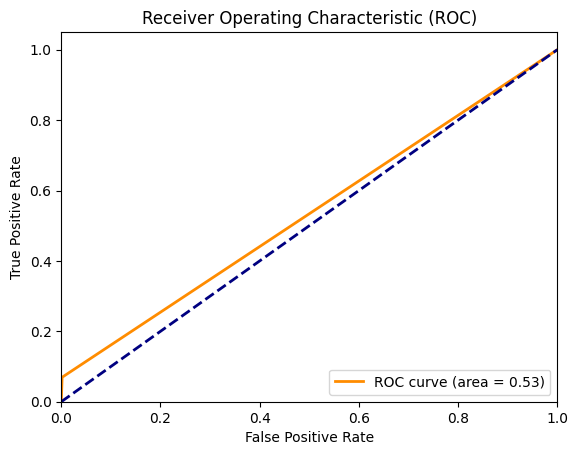

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_200)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

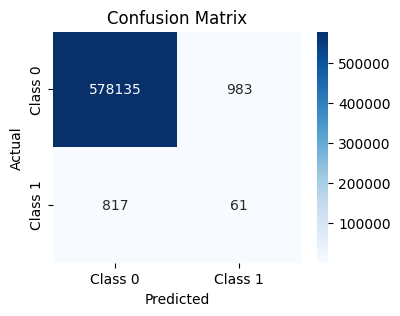

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_200)

# Define class labels (modify if needed)
class_labels = ['Class 0', 'Class 1']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()